# Evolving Population

In this notebook we focus on reproducing the evolution trajectory of a population. Our end goal is to visualize multiple snapshots of high-dimensional populations and map them to 2D using KDE density contour plot. With this plot, we show how TS-DE balances the exploration-exploitation trade-off using initial diversification followed by approaching and concentrating around the optimal solution.

In [90]:
import sys
import math
from typing import List
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.decomposition import PCA

sys.path.append('../')

from util.common import zero_population, linear_bayesian_utility_model
from util.TS_DE.TS_DE import TS_DE


**Reproducing left-hand side Figure 6.2.:**

**Parameter setup:**
- *d=10*
- *M=40*
- *T=100*
- *mu=0.08*
- *sigma=1*
- *lambda_=1*

**Claims we are testing:**
(i) TS-DE first diversifies and then concentrates around the optimal solution.

In [78]:
np.random.seed(seed=0)

# Initial setting for TS-DE and DE
d = 40
M = 20
T = 60
mu = 0.1

# Theta star - optimal theta - parametrization of the linear Bayesian utility model for
# which we aim to optimize the protein design.
theta_star = np.random.multivariate_normal(np.zeros(d), np.eye(d))

# Sequence that maximizes the utility function (used for visualizations).
x_star = [0 if theta_i < 0 else 1 for theta_i in theta_star]

In [79]:
# Execute TS-DE
populations, thetas = TS_DE(d=d,
                            T=T,
                            M=M,
                            theta_star=theta_star,
                            S_0=zero_population(d=d, M=M),
                            mu=mu,
                            sigma=1,
                            lambda_=1,
                            f=linear_bayesian_utility_model)

In [107]:
# Helper function to visualize the population evolution
def visualize_population(populations: List[List[np.ndarray]],
                         indices: List[int],
                         pca_fit: PCA,
                         x_star: list) -> None:
    if len(indices) != 6:
        raise RuntimeError('Population visualization supports exactly 6 populations')
    nrows = 2
    ncols = 3
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    fig.suptitle('Population evolution - PCA 2D KDE density contour plot', fontsize=14)

    for i in range(len(indices)):
        ix_row = math.floor(i / ncols)
        ix_col = i % ncols
        ix_S = indices[i]
        S = populations[ix_S]
        # Perform PCA on the population
        S_pca = pca_fit.transform(S)
        x_star_pca = pca_fit.transform(np.array(x_star).reshape(1, -1))
        df_S_pca = pd.DataFrame(data=S_pca,
                                columns=['PC1', 'PC2'])

        # Plot the population using KDE density contour plot
        plot = sns.kdeplot(ax=axes[ix_row, ix_col],
                           data=df_S_pca,
                           x='PC1',
                           y='PC2',
                           fill=True,
                           cmap='Blues')
        axes[ix_row, ix_col].text(
            3.60, 1.75, f't={indices[i]}',
            horizontalalignment='center',
            verticalalignment='center',
        )

        axes[ix_row, ix_col].plot(x_star_pca[0][0], x_star_pca[0][1], marker='x', color='red')
        axes[ix_row, ix_col].set_xlim([-2, 4])
        axes[ix_row, ix_col].set_ylim([-2, 2])

        if ix_col != 0:
            plot.set(ylabel=None)

        if ix_row != 1:
            plot.set(xlabel=None)

    red_marker = mlines.Line2D([], [], color='red', marker='x', linestyle='None',
                              markersize=7, label='optimal solution')
    plt.legend(handles=[red_marker], loc='lower center', bbox_to_anchor=(0.5, 0., 0., 0.5))
    plt.savefig('../plots/evolving_population_2d.png')
    plt.show()

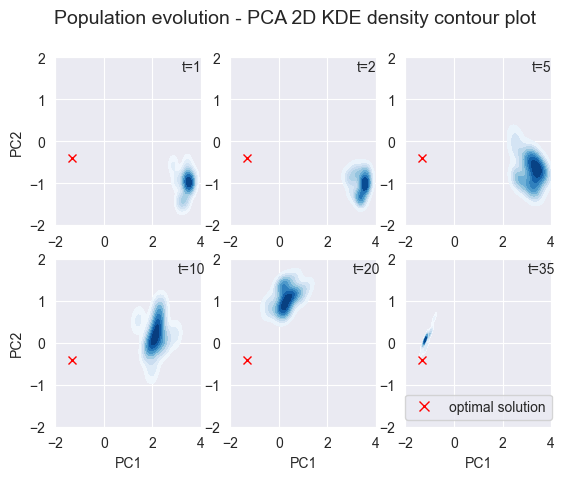

In [108]:
# Fit PCA on all populations - this is done so that we have the same mapping for all steps in the visualization
arr_populations = np.array([np.array(S) for S in populations]).reshape(M * (T + 1), d)
pca = PCA(n_components=2)
pca_fit = pca.fit(arr_populations)

visualize_population(populations=populations,
                     indices=[1, 2, 5, 10, 20, 35],
                     pca_fit=pca_fit,
                     x_star=x_star)